In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from data_load import load_aggregate_data, get_shipping_doors_volume
from distance_map import load_distance_map
from gridload import load_grid_graph, plot_grid
from data_analyze import calculate_metrics
from sklearn.linear_model import LinearRegression
from test import backtest_model

# Which Doors Are Shipping?

In [2]:
dc = 820
df = load_aggregate_data(dc=820)

In [4]:
x = set(df["to_locn"])

# Rotating Club Door Center

In [2]:
# Load dataframe and calculate distances
dc = 800
df = load_aggregate_data(dc=dc)
dist_map = load_distance_map(dc)

def calculate_distance(row):
    start = row["from_locn"]
    end = row["to_locn"]
    dist = round(dist_map.get((start, end), 100) * 6.67, 0)
    return dist

df["distances"] = df.apply(calculate_distance, axis=1)

In [3]:
# Dock door numbers

# DC 800 Shipping
dock_doors = set([i for i in range(49, 168, 2)] + [i for i in range(14, 61, 2)] + [i for i in range(138, 161, 2)])
dock_doors_to_remove = set([46, 135])
dock_doors = sorted(list(dock_doors - dock_doors_to_remove))

In [4]:
# Find top clubs
shipping_doors_counts = []
for dock_door in dock_doors:
    dock_door = str(dock_door)
    df_filtered_to = df[df["to_locn"] == dock_door]
    df_filtered_from = df[df["from_locn"] == dock_door]
    df_filtered = pd.concat([df_filtered_from, df_filtered_to])
    shipping_doors_counts.append([int(dock_door), df_filtered.shape[0]])

# sort by count of LPNs
shipping_doors_counts.sort(key=lambda x: x[1], reverse=False)

In [22]:
# Create rotation by updating dist_map
def create_rotated_dist_map(dc, shipping_doors_counts, middle_index = 10):
    """
    Create new dist_map by centering shipping doors based on volume around the middle_index. 
    """
    # Sort by volume
    shipping_doors_counts.sort(key=lambda x: x[1], reverse=True)

    # Sort by shipping door number
    shipping_doors = [x[0] for x in shipping_doors_counts]
    shipping_doors.sort()

    # get middle shipping door
    i = 0
    new_door_order = []
    while i < len(shipping_doors_counts):
        # add on left when increasing
        if i % 2 == 0:
            new_door_order.append(shipping_doors_counts[i][0])
        else:
            new_door_order.insert(0, shipping_doors_counts[i][0])
        i += 1
    # rotate so that shipping_door_counts[i0[0] is on middle_index
    while (new_door_order[middle_index] != shipping_doors_counts[0][0]):
        new_door_order.append(new_door_order.pop(0))
    
    # create dict: {old : new}
    old_new_door_map = {}
    for i in range(len(new_door_order)):
        old_new_door_map[shipping_doors[i]] = shipping_doors[i]
    # loop through old_dist_map by keys and create new dict wherever start/end location in shipping doors set
    new_dist_map = {}
    dist_map = load_distance_map(dc)
    shipping_doors_set = set([str(x) for x in shipping_doors])
    for pair in dist_map.keys():
        if pair[0] in shipping_doors_set and pair[1] in shipping_doors_set:
            new_dist_map[(str(old_new_door_map[int(pair[0])]), str(old_new_door_map[int(pair[1])]))] = dist_map[pair]
        elif pair[0] in shipping_doors_set:
            new_dist_map[(str(old_new_door_map[int(pair[0])]), pair[1])] = dist_map[pair]
        elif pair[1] in shipping_doors_set:
            new_dist_map[(pair[0], str(old_new_door_map[int(pair[1])]))] = dist_map[pair]
        else:
            new_dist_map[pair] = dist_map[pair]
    return new_dist_map

new_dist_map = create_rotated_dist_map(dc=800, shipping_doors_counts=shipping_doors_counts, middle_index=int(len(shipping_doors_counts) / 10))

# Linear Programming Method

In [1]:
import pulp
from pulp import value
import warnings
warnings.filterwarnings("ignore")

In [9]:
dc = 800

In [3]:
dock_doors = sorted(list(set(
            [i for i in range(49, 168, 2)]
            + [i for i in range(14, 61, 2)]
            + [i for i in range(138, 161, 2)]
        )))
df = load_aggregate_data(dc=dc)
from_locns = sorted(list(set(df["from_locn"])))

In [12]:
num_clubs = len(dock_doors)
num_doors = len(dock_doors)
num_from_locns = len(from_locns)

In [10]:
# Load in distance map
dist_map = load_distance_map(dc=dc)

In [17]:
# row = dock door -> column = from_locn
distances = [[0 for i in range(num_from_locns)] for j in range(num_doors)]
for i in range(num_doors):
    for j in range(num_from_locns):
        distances[i][j] = dist_map.get((str(dock_doors[i]), str(from_locns[j])), 50)

In [ ]:
# pretty print distance matrix
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in distances]))

In [31]:
# number of pallets delivered from column (from_locn) to row (dock_door)
pallets = [[0 for i in range(num_from_locns)] for j in range(num_doors)]
pallets_pivot = df.pivot_table(index='to_locn', columns='from_locn', aggfunc='size')

In [49]:
for i in range(num_doors):
    for j in range(num_from_locns):
        # df_filtered = df[(df["from_locn"] == str(from_locns[j])) & (df["to_locn"] == str(dock_doors[i]))]
        # pallets[i][j] = df_filtered.shape[0]
        try:
            if pd.isnull(pallets_pivot.at[str(dock_doors[i]), str(from_locns[j])]):
                pallets[i][j] = 0
            else:
                pallets[i][j] = pallets_pivot.at[str(dock_doors[i]), str(from_locns[j])]
        except:
            pallets[i][j] = 0

In [50]:
# pretty print pallet matrix
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in pallets]))

0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	24.0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	18.0	0	0	25.0	0	0	0	0	0	0	0	0	0	0	11.0	2.0	0	0	0	13.0	1.0	0	27.0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
20.0	26.0	34.0	29.0	31.0	23.0	13.0	36.0	23.0	22.0	28.0	17.0	17.0	23.0	0	22.0	0	25.0	25.0	12.0	0	0	0	0	3.0	0	3.0	2.0	0	1.0	0	0	0	0	0	0	0	0	0	0	3.0	0	2.0	0	1.0	0	0	0	1.0	0	2.0	3.0	1.0	0	2.0	0	5.0	0	0	0	0	3.0	47.0	78.0	18.0	0	3.0	2.0	0	13.0	10.0	6.0	6.0	0	0	6.0	0	9.0	0	0	7.0	0	6.0	0	0	0	0	0
20.0	14.0	22.0	20.0	14.0	18.0	16.0	23.0	14.0	23.0	17.0	24.0	15.0	14.0	0	16.0	0	18.0	19.0	14.0	0	1.0	0	0	3.0	0	3.0	3.0	1.0	5.0	0	0	0	0	0	0	0	0	2.0	0	12.0	0	6.0	0	5.0	0	0	0	3.0	0	7.0	4.0	4.0	0	6.0	5.0	8.0	0	0	3.0	4.0	3.0	94.0	79.0	13.0	0	7.0	23.0	8.0	10.0	53.0	7.0	7.0	0	0	8.0	0	7.0	0	0	6.0	0	6.0	0	0	0	0	0
20.0	21.0	21.0	33.0	26.0	21.0	18.0	29.0	36.0	23.0	22.0	20.0	29.0	19.0	0	33.0	1.0	29.0	18.0	18.0	0	1.0	0	0	9.0	0	0	3.0	3.0	7.0	0	0	0	0	0	0	0	0	2.0	0	8.0	0	6.0	0	5.0	0	0	0	9.0	0	5.0	3.0	5.0	0	7.0	6.0	6.0	0	5.0	

In [69]:
# Create a linear programming problem
lp_problem = pulp.LpProblem("Shipping_Dock_Door_Allocation", pulp.LpMinimize)

In [70]:
# Define decision variables
x = {}
for t in range(num_doors):
    for g in range(num_doors):
        x[(t, g)] = pulp.LpVariable(f"x_{t}_{g}", cat='Binary')

In [71]:
# Define the objective function
lp_problem += pulp.lpSum(x[(t, g)] * distances[g][z] * pallets[t][z] for t in range(num_clubs) for g in range(num_doors) for z in range(num_from_locns))

In [72]:
# Define constraints
# Each club must be assigned to a dock_door

for t in range(num_clubs):
    lp_problem += pulp.lpSum(x[(t, g)] for g in range(num_doors)) == 1

# Each gate can be assigned to only one or no trucks
for g in range(num_doors):
    lp_problem += pulp.lpSum(x[(t, g)] for t in range(num_clubs)) <= 1

In [79]:
initial_objective = 0
for t in range(num_clubs):
    for g in range(num_doors):
        for z in range(num_from_locns):
            if t == g:
                initial_objective += distances[g][z] * pallets[t][z]
initial_objective

14724319.0

In [55]:
# Solve the linear programming problem
sol = lp_problem.solve()

In [58]:
dock_doors

[14,
 16,
 18,
 20,
 22,
 24,
 26,
 28,
 30,
 32,
 34,
 36,
 38,
 40,
 42,
 44,
 46,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 63,
 65,
 67,
 69,
 71,
 73,
 75,
 77,
 79,
 81,
 83,
 85,
 87,
 89,
 91,
 93,
 95,
 97,
 99,
 101,
 103,
 105,
 107,
 109,
 111,
 113,
 115,
 117,
 119,
 121,
 123,
 125,
 127,
 129,
 131,
 133,
 135,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 163,
 165,
 167]

In [57]:
old_new_map = {}
if pulp.LpStatus[lp_problem.status] == "Optimal":
    print("Optimal Solution Found:")
    for t in range(num_clubs):
        for g in range(num_doors):
            distance = 0
            if x[(t, g)].value() == 1:
                for z in range(num_from_locns):
                    distance += distances[g][z]
                distance /= num_from_locns   
                print(f"Assign Dock Door {dock_doors[t]} to New Dock Door {dock_doors[g]} (Average Distance: {round(distance,2)} units)")
else:
    print("No optimal solution found.")


Optimal Solution Found:
Assign Dock Door 14 to New Dock Door 20 (Average Distance: 85.05 units)
Assign Dock Door 16 to New Dock Door 22 (Average Distance: 83.61 units)
Assign Dock Door 18 to New Dock Door 26 (Average Distance: 81.02 units)
Assign Dock Door 20 to New Dock Door 34 (Average Distance: 76.8 units)
Assign Dock Door 22 to New Dock Door 30 (Average Distance: 78.36 units)
Assign Dock Door 24 to New Dock Door 36 (Average Distance: 75.48 units)
Assign Dock Door 26 to New Dock Door 32 (Average Distance: 77.34 units)
Assign Dock Door 28 to New Dock Door 40 (Average Distance: 73.84 units)
Assign Dock Door 30 to New Dock Door 51 (Average Distance: 72.16 units)
Assign Dock Door 32 to New Dock Door 42 (Average Distance: 73.09 units)
Assign Dock Door 34 to New Dock Door 24 (Average Distance: 82.27 units)
Assign Dock Door 36 to New Dock Door 48 (Average Distance: 70.41 units)
Assign Dock Door 38 to New Dock Door 44 (Average Distance: 72.39 units)
Assign Dock Door 40 to New Dock Door 49 (

In [67]:
optimal_objective = value(lp_problem.objective)
optimal_objective

13991976.0

# Testing (Presentation Visuals)

### Bubbles

In [2]:
dc = 820
old_distance_map = load_distance_map(dc=dc)

In [3]:
bubbles = []
grid, dock_map = load_grid_graph(f"Crossdock Maps/DC{dc}.csv")

In [4]:
# shipping location heatmap
shipping_door_volume = sorted(get_shipping_doors_volume(dc=dc), key=lambda x: x[1], reverse=True)
for x in shipping_door_volume:
    bubbles.append((dock_map[str(x[0])], x[1]))

In [5]:
bubbles = []
old_new_door_map = {31: 68, 68: 31, 70: 70, 161: 72, 72: 161, 150: 74, 74: 150, 35: 76, 76: 35, 122: 141, 78: 122, 80: 80, 106: 58, 82: 110, 173: 84, 84: 173, 138: 86, 86: 138, 24: 88, 88: 24, 58: 106, 37: 108, 108: 37, 110: 82, 43: 112, 112: 43, 66: 114, 114: 66, 27: 116, 116: 27, 130: 118, 118: 130, 163: 120, 120: 163, 141: 122}
for x in sorted(shipping_door_volume, key=lambda x: x[1], reverse=True):
    if x[0] in old_new_door_map.keys():
        bubbles.append((dock_map[str(old_new_door_map[int(x[0])])], x[1]))
bubbles

[((59, 147), 4818),
 ((59, 167), 4659),
 ((59, 143), 4431),
 ((59, 195), 4165),
 ((59, 139), 4139),
 ((38, 113), 3911),
 ((59, 135), 3864),
 ((59, 179), 3799),
 ((59, 131), 3785),
 ((59, 183), 3646),
 ((59, 103), 2969),
 ((59, 171), 2874),
 ((59, 123), 2521),
 ((59, 187), 2145),
 ((59, 131), 2131),
 ((38, 81), 1871),
 ((59, 229), 1832),
 ((38, 219), 1732),
 ((59, 115), 1731),
 ((38, 217), 1716),
 ((38, 223), 1685),
 ((38, 227), 1663),
 ((38, 91), 1593),
 ((38, 93), 1588),
 ((38, 211), 1474),
 ((59, 185), 1359),
 ((59, 133), 1331),
 ((59, 181), 1309),
 ((59, 137), 1181),
 ((59, 177), 1052),
 ((59, 141), 1013),
 ((59, 173), 1012),
 ((59, 145), 954),
 ((59, 169), 187),
 ((59, 165), 84)]

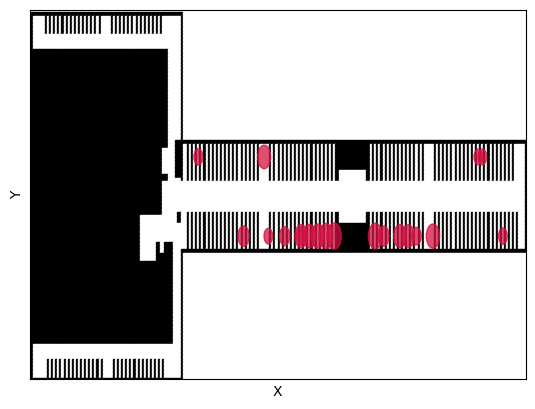

In [6]:
plot_grid(grid, bubbles=bubbles[:20])

### Dock Door Allocation

In [9]:
# Clustering
new_distance_map, old_new_door_map = optimize_dock_layout(
    dc=dc,
    shipping_doors_counts=shipping_door_volume,
    method="linprog",
    # calibrationDate=datetime(2024, 5, 19),
)

Optimal Solution Improvement: 5.299607238696857%


### Post Allocation Bubbles

In [10]:
bubbles = []
for x in sorted(shipping_door_volume, key=lambda x: x[1], reverse=True)[:25]:
    bubbles.append((dock_map[str(old_new_door_map[int(x[0])])], x[1]))
bubbles

[((59, 165), 4818),
 ((59, 147), 4659),
 ((59, 143), 4431),
 ((59, 173), 4165),
 ((59, 141), 4139),
 ((59, 139), 3911),
 ((59, 145), 3864),
 ((59, 169), 3799),
 ((59, 167), 3785),
 ((59, 171), 3646),
 ((59, 181), 3038),
 ((59, 175), 2973),
 ((59, 179), 2969),
 ((59, 129), 2925),
 ((59, 191), 2874),
 ((59, 183), 2821),
 ((59, 135), 2750),
 ((59, 133), 2731),
 ((59, 137), 2724),
 ((59, 177), 2637),
 ((59, 125), 2550),
 ((59, 195), 2522),
 ((59, 185), 2521),
 ((59, 189), 2486),
 ((59, 131), 2467)]

# Efficient Frontier for # Dock Door Rearrangements

In [103]:
from distance_map import optimize_dock_layout

dc = 800
shipping_doors_counts = get_shipping_doors_volume(dc=dc)
old_distance_map = load_distance_map(dc=dc)

In [106]:
from models import NearestNeighbor

outcomes = []
for k in range(5, len(shipping_doors_counts), 5):
    new_distance_map, old_new_door_map = optimize_dock_layout(
        dc=dc,
        shipping_doors_counts=shipping_doors_counts,
        method="cluster",  # cluster, greedy, linprog
        top_k=k,
    )
    print(old_new_door_map)
    improvements = []
    for day in range(15, 45, 5):
        if day > 30:
            date = datetime(2024, 6, day % 30)
        else:
            date = datetime(2024, 5, day)
        tasks = load_aggregate_data(dc=dc, date=date)
        routingOldShippingDocks = NearestNeighbor(
            distance_map=old_distance_map,
            num_forklifts=20,
            tasks=tasks,
        )
        oldDistance = backtest_model(routingOldShippingDocks, dc=dc)
        routingNewShippingDocks = NearestNeighbor(
            distance_map=new_distance_map,
            num_forklifts=20,
            tasks=tasks,
        )
        newDistance = backtest_model(routingNewShippingDocks, dc=dc)
        improvements.append(100 * (oldDistance - newDistance) / oldDistance)
    print(sum(improvements) / len(improvements))
    outcomes.append(sum(improvements) / len(improvements))

{140: 107, 107: 140, 138: 109, 109: 138, 85: 111, 111: 85, 133: 113, 113: 133, 93: 115, 115: 93}
1.0780575574303002
{83: 101, 101: 83, 144: 103, 103: 144, 95: 105, 105: 95, 140: 107, 107: 140, 138: 109, 109: 138, 85: 111, 111: 85, 133: 113, 113: 133, 93: 115, 115: 93, 123: 117, 117: 123, 157: 119, 119: 157}
1.3000464294733869
{145: 97, 97: 145, 119: 157, 99: 119, 83: 101, 101: 83, 144: 103, 103: 144, 95: 105, 105: 95, 140: 107, 107: 140, 138: 109, 109: 138, 85: 111, 111: 85, 133: 113, 113: 125, 93: 115, 115: 93, 123: 146, 117: 123, 157: 119, 142: 121, 121: 142, 146: 123, 125: 113}
1.7507096777759756
{163: 91, 91: 163, 67: 93, 93: 115, 101: 83, 95: 105, 145: 97, 97: 145, 119: 157, 99: 119, 83: 101, 144: 103, 103: 144, 105: 95, 140: 107, 107: 140, 138: 109, 109: 138, 85: 111, 111: 85, 133: 113, 113: 125, 115: 93, 123: 146, 117: 123, 157: 119, 142: 121, 121: 142, 146: 123, 125: 113, 159: 127, 127: 159, 153: 129, 129: 153}
2.6490242694162753
{91: 163, 85: 111, 158: 89, 89: 158, 163: 91, 67

[1.0780575574303002, 1.3000464294733869, 1.7507096777759756, 2.6490242694162753, 2.19938290572064, 1.639604684719231, 1.117639191629025, 1.2086295069470625, 1.1138450698876203, 1.00434316618889, 1.0234365715879383, 0.9103362507014087, 0.2795584013624176, -0.5248918415061831, -1.78106966931139, -2.1126707207715656, -2.0700504405437408, -2.1155706220599866]


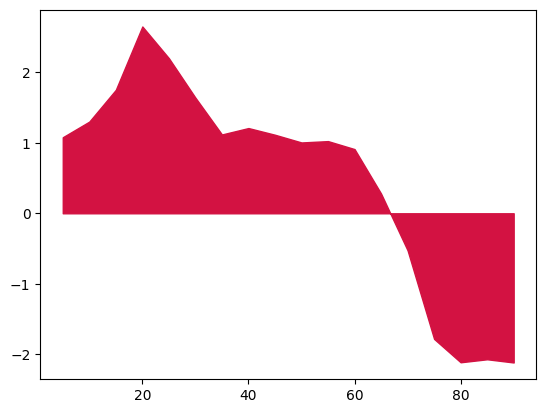

In [108]:
k = [i for i in range(5, len(shipping_doors_counts), 5)]
print(outcomes)
plt.fill_between(k, outcomes, color="#D31242")
plt.show()